# Evaluation Notebook

Here each model will be evaluated with the full dataset

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
import seaborn as sns
import sys
import time
import umap
import json

from torch import cuda
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from ipywidgets import widgets, interactive

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.layouts import row
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models import ColumnDataSource

from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

sys.path.insert(0, '../scripts')

import vsc
import vae

In [2]:
torch.manual_seed(22)
np.random.seed(22)

device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

data_dir = '../../../dataset/'
model_path = '../../../results/models/vae/vaez256.pth'
metadata_dir = '../../../metadata/'
eval_dir='../../../results/models/vae/'
prefix = 'vaez256_'
z = 256

batch_size = 128
alpha = 0.05
beta = 1
c = 200


cuda


In [3]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 6
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))
    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, image_dataset.class_to_idx

In [4]:
train_data, _, test_data, label_mapping = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  879151
Val split:  219787
Test split:  274734


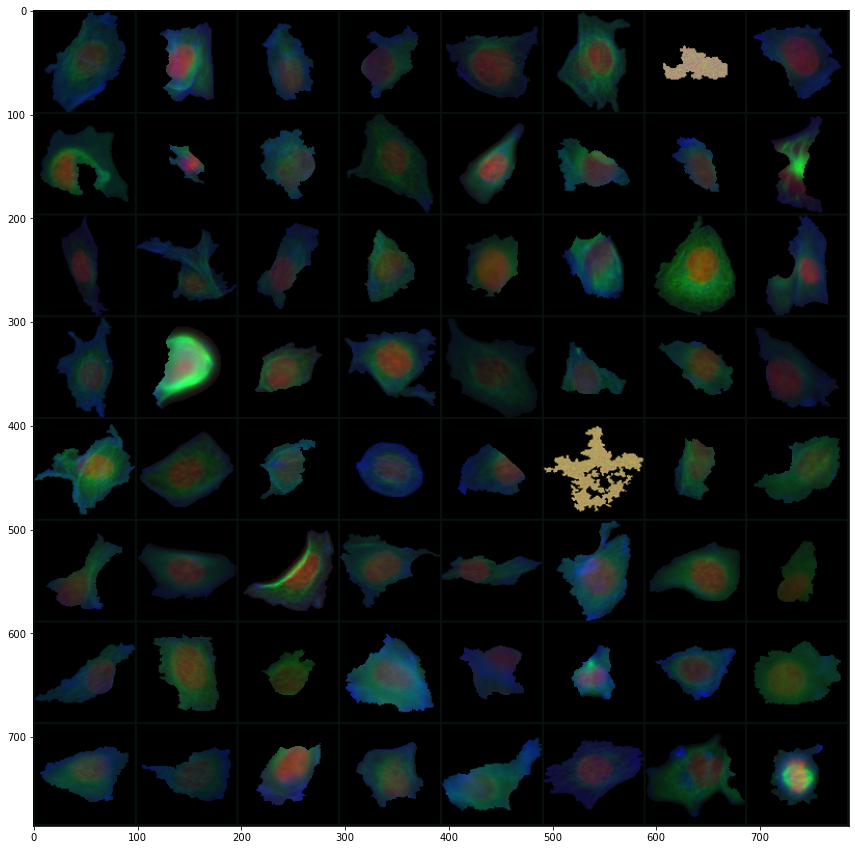

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
batch, _ = next(iter(train_data))
imshow(torchvision.utils.make_grid(batch[:64]))

In [6]:
label_mapping

{"3,3'-diaminobenzidine": 0,
 '5-fluorouracil': 1,
 'AG-1478': 2,
 'ALLN': 3,
 'AZ-A': 4,
 'AZ-B': 5,
 'AZ-C': 6,
 'AZ-H': 7,
 'AZ-I': 8,
 'AZ-J': 9,
 'AZ-K': 10,
 'AZ-L': 11,
 'AZ-M': 12,
 'AZ-N': 13,
 'AZ-O': 14,
 'AZ-U': 15,
 'AZ138': 16,
 'AZ235': 17,
 'AZ258': 18,
 'AZ701': 19,
 'AZ841': 20,
 'Cdk1 inhibitor III': 21,
 'Cdk1-2 inhibitor (NU6102)': 22,
 'DMSO': 23,
 'H-7': 24,
 'ICI-182,780': 25,
 'LY-294002': 26,
 'MG-132': 27,
 'PD-150606': 28,
 'PD-169316': 29,
 'PD-98059': 30,
 'PP-2': 31,
 'SB-202190': 32,
 'SB-203580': 33,
 'SP-600125': 34,
 'TKK': 35,
 'UNKNOWN': 36,
 'UO-126': 37,
 'Y-27632': 38,
 'acyclovir': 39,
 'aloisine A': 40,
 'alsterpaullone': 41,
 'anisomycin': 42,
 'aphidicolin': 43,
 'arabinofuranosylcytosine': 44,
 'atropine': 45,
 'bleomycin': 46,
 'bohemine': 47,
 'brefeldin A': 48,
 'bryostatin': 49,
 'calpain inhibitor 2 (ALLM)': 50,
 'calpeptin': 51,
 'camptothecin': 52,
 'carboplatin': 53,
 'caspase inhibitor 1 (ZVAD)': 54,
 'cathepsin inhibitor I': 55,
 '

In [7]:
model = vae.VAE(z)
loss_function = vae.loss_function
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
print(model)

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

In [8]:
test_z = None
test_labels = None
total_batches = len(test_data)
batch_log = total_batches // 20
with torch.no_grad():
    for batch_id, (data, labels) in enumerate(test_data):
        data = data.to(device)
        encoded = model.encode(data)
        batch_z = model.reparameterize(*encoded)
        if test_z is not None:
            test_z = torch.cat((test_z, batch_z), dim=0)
            test_labels = torch.cat((test_labels, labels))
        else:
            test_z = batch_z
            test_labels = labels
        
        if batch_id % batch_log == 0:
            print('Processing batch ', batch_id, '/', total_batches)

test_z = test_z.cpu()
test_labels = test_labels.cpu()

Processing batch  0 / 2147
Processing batch  107 / 2147
Processing batch  214 / 2147
Processing batch  321 / 2147
Processing batch  428 / 2147
Processing batch  535 / 2147
Processing batch  642 / 2147
Processing batch  749 / 2147
Processing batch  856 / 2147
Processing batch  963 / 2147
Processing batch  1070 / 2147
Processing batch  1177 / 2147
Processing batch  1284 / 2147
Processing batch  1391 / 2147
Processing batch  1498 / 2147
Processing batch  1605 / 2147
Processing batch  1712 / 2147
Processing batch  1819 / 2147
Processing batch  1926 / 2147
Processing batch  2033 / 2147
Processing batch  2140 / 2147


In [9]:
np.save(eval_dir + prefix + 'encoded_z.npy', test_z.numpy())
np.save(eval_dir + prefix + 'labels.npy', test_labels.numpy())
with open(eval_dir + prefix + 'label_mapping.json', 'w') as file:
    json.dump(label_mapping, file)

In [6]:
test_z = torch.from_numpy(np.load(eval_dir + prefix + 'encoded_z.npy')).float()
test_labels = torch.from_numpy(np.load(eval_dir + prefix + 'labels.npy')).float()
label_mapping = None
with open(eval_dir + prefix + 'label_mapping.json', 'r') as file:
    label_mapping = json.load(file)

In [7]:
metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]

comp_list = compound_folder['Image_Metadata_Compound'].unique()

compound_folder


,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
13103,Week9_090907_G11_s4_w102E35E38-958C-4E30-81B9-...,DMSO,9837
13151,Week9_090907_G11_s4_w1239FB180-ECF6-41BE-B6BA-...,DMSO,9838
13127,Week9_090907_G11_s4_w1ADA58D05-801C-4342-BC02-...,DMSO,9839
13199,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,DMSO,9840


In [10]:
label_mapping = {v: k for k, v in label_mapping.items()}
comp_list = np.array(list(label_mapping.keys()))

In [8]:
test_compounds = []

for label in test_labels:
    compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
    test_compounds.append(compound)
    #test_compounds.append(label_mapping[label.item()])

test_compounds = np.array(test_compounds)

In [13]:
sliced_data = test_z
sliced_labels = test_compounds
#not_dmso = test_compounds != 'DMSO'
#sliced_data = test_z[not_dmso]
#sliced_labels =test_compounds[not_dmso]

In [14]:
clf_train_idx = int(len(sliced_data) * 0.8)
clf_train_split = sliced_data[:clf_train_idx].numpy()
clf_train_labels = sliced_labels[:clf_train_idx]

clf_val_split = sliced_data[clf_train_idx:].numpy()
clf_val_labels = sliced_labels[clf_train_idx:]

In [15]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier(strategy='stratified', random_state=22)
classifier.fit(clf_train_split, clf_train_labels)
pred = classifier.predict(clf_val_split)
print(classification_report(clf_val_labels, pred, digits=4))

                            precision    recall  f1-score   support

     3,3'-diaminobenzidine     0.0113    0.0114    0.0114      1312
            5-fluorouracil     0.0067    0.0066    0.0067      1358
                   AG-1478     0.0114    0.0117    0.0115      1281
                      ALLN     0.0067    0.0072    0.0069      1249
                      AZ-A     0.0076    0.0076    0.0076      1313
                      AZ-B     0.0126    0.0121    0.0123      1326
                      AZ-C     0.0097    0.0089    0.0093      1343
                      AZ-H     0.0102    0.0102    0.0102      1274
                      AZ-I     0.0060    0.0063    0.0061      1275
                      AZ-J     0.0094    0.0099    0.0097      1312
                      AZ-K     0.0111    0.0106    0.0108      1320
                      AZ-L     0.0060    0.0062    0.0061      1294
                      AZ-M     0.0107    0.0102    0.0104      1377
                      AZ-N     0.0100    0.0102

In [19]:
classifier = GaussianNB()
classifier.fit(clf_train_split, clf_train_labels)
pred = classifier.predict(clf_val_split)
report = classification_report(clf_val_labels, pred, digits=4)
print(report)

                            precision    recall  f1-score   support

     3,3'-diaminobenzidine     0.0134    0.0076    0.0097      1312
            5-fluorouracil     0.0176    0.0133    0.0151      1358
                   AG-1478     0.0072    0.0008    0.0014      1281
                      ALLN     0.0155    0.0016    0.0029      1249
                      AZ-A     0.0258    0.0487    0.0337      1313
                      AZ-B     0.0240    0.0075    0.0115      1326
                      AZ-C     0.0419    0.0261    0.0321      1343
                      AZ-H     0.0279    0.0330    0.0302      1274
                      AZ-I     0.0505    0.0267    0.0349      1275
                      AZ-J     0.0118    0.0023    0.0038      1312
                      AZ-K     0.0288    0.0136    0.0185      1320
                      AZ-L     0.0106    0.0046    0.0064      1294
                      AZ-M     0.0497    0.1126    0.0690      1377
                      AZ-N     0.0082    0.0039

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifier = QuadraticDiscriminantAnalysis()

classifier.fit(clf_train_split, clf_train_labels)
pred = classifier.predict(clf_val_split)
string_clr = classification_report(clf_val_labels, pred, digits=4)
print(string_clr)

                            precision    recall  f1-score   support

     3,3'-diaminobenzidine     0.0194    0.0122    0.0150      1312
            5-fluorouracil     0.0165    0.0133    0.0147      1358
                   AG-1478     0.0000    0.0000    0.0000      1281
                      ALLN     0.0400    0.0056    0.0098      1249
                      AZ-A     0.0284    0.0526    0.0369      1313
                      AZ-B     0.0279    0.0106    0.0153      1326
                      AZ-C     0.0690    0.0491    0.0574      1343
                      AZ-H     0.0290    0.0369    0.0325      1274
                      AZ-I     0.0550    0.0306    0.0393      1275
                      AZ-J     0.0210    0.0053    0.0085      1312
                      AZ-K     0.0294    0.0152    0.0200      1320
                      AZ-L     0.0165    0.0085    0.0112      1294
                      AZ-M     0.0492    0.1162    0.0691      1377
                      AZ-N     0.0107    0.0055

In [18]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(280, 200, 150), random_state=22,
                           max_iter=300, early_stopping=True, verbose=True)
classifier.fit(clf_train_split, clf_train_labels)
pred = classifier.predict(clf_val_split)
report = classification_report(clf_val_labels, pred, digits=4)
print(report)

Iteration 1, loss = 4.47473115
Validation score: 0.051272
Iteration 2, loss = 4.39029354
Validation score: 0.055310
Iteration 3, loss = 4.35479611
Validation score: 0.056361
Iteration 4, loss = 4.32602723
Validation score: 0.056904
Iteration 5, loss = 4.29972865
Validation score: 0.057396
Iteration 6, loss = 4.27638115
Validation score: 0.057804
Iteration 7, loss = 4.25495783
Validation score: 0.056836
Iteration 8, loss = 4.23615705
Validation score: 0.056938
Iteration 9, loss = 4.21821832
Validation score: 0.055598
Iteration 10, loss = 4.20267656
Validation score: 0.055157
Iteration 11, loss = 4.18795336
Validation score: 0.054529
Iteration 12, loss = 4.17443879
Validation score: 0.053935
Iteration 13, loss = 4.16261368
Validation score: 0.054139
Iteration 14, loss = 4.15196907
Validation score: 0.052493
Iteration 15, loss = 4.14197366
Validation score: 0.051611
Iteration 16, loss = 4.13187374
Validation score: 0.052951
Iteration 17, loss = 4.12423439
Validation score: 0.051356
Valida

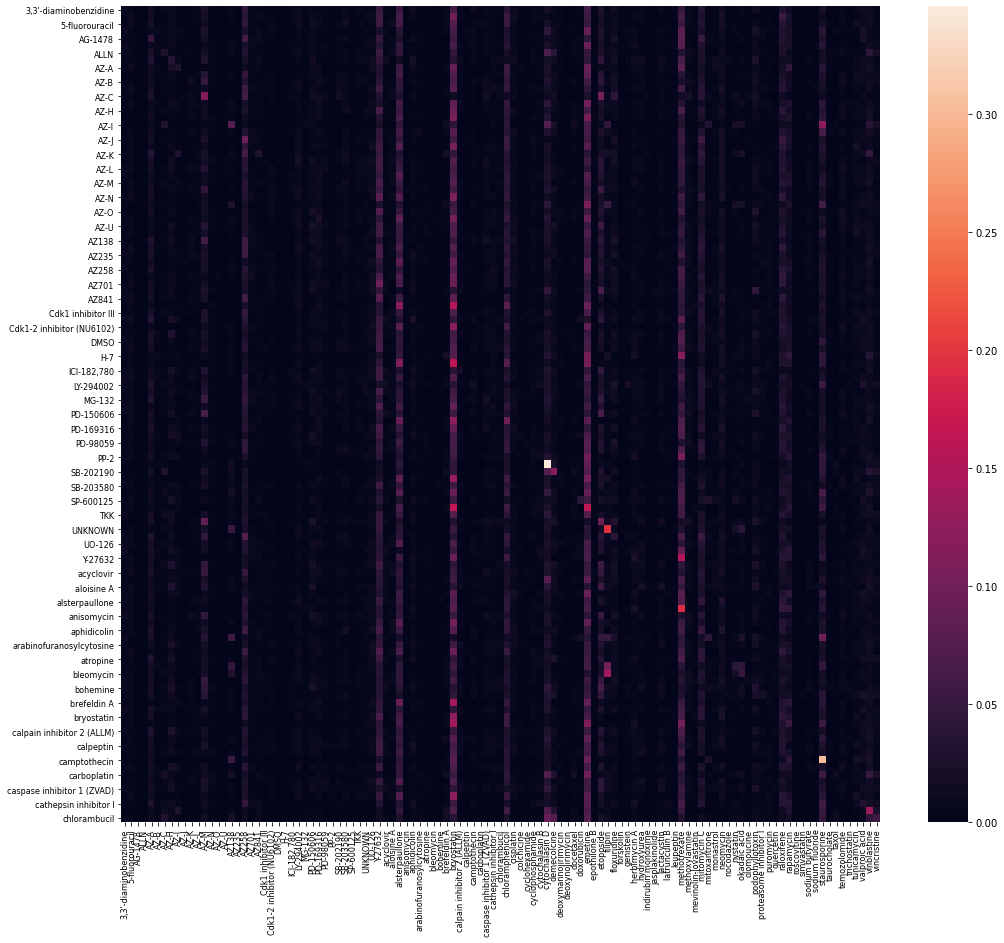

In [53]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(17,15))
fig = sns.heatmap(confusion_matrix(clf_val_labels, pred, labels=comp_list, normalize='true'), xticklabels=comp_list, annot=False)
fig.set_xticklabels(comp_list, size=8)
fig.set_yticklabels(comp_list, size=8)
plt.show()

In [52]:
confusion_matrix(clf_val_labels, pred, labels=comp_list, normalize='true')

array([[0.00762195, 0.00304878, 0.00152439, ..., 0.01371951, 0.01219512,
        0.00457317],
       [0.00441826, 0.01325479, 0.00294551, ..., 0.00736377, 0.01178203,
        0.00441826],
       [0.00156128, 0.01092896, 0.00078064, ..., 0.00936768, 0.01483216,
        0.00468384],
       ...,
       [0.00535168, 0.00535168, 0.        , ..., 0.02981651, 0.0175841 ,
        0.01146789],
       [0.00315457, 0.00315457, 0.        , ..., 0.00946372, 0.1340694 ,
        0.02208202],
       [0.00517751, 0.00591716, 0.00073964, ..., 0.00739645, 0.04215976,
        0.05547337]])

## Distances
How far apart are compounds, and a heatmap to try to identify any patterns in the data

### Mahalanobis distance

In [8]:
def compound_mean(compound):
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_matrix = test_z[is_compound].numpy()
    #covar = np.cov(comp_matrix.T)
    mean = np.mean(comp_matrix, axis=0)
    mean = mean.reshape(z,1)
    return mean

def mahalanobis_dist(x, y, covar): 
    delta = x - y
    mahalanobis = delta.T @ np.linalg.inv(covar) @ delta
    mahalanobis = np.sqrt(mahalanobis)
    return np.diag(mahalanobis)[0]

In [9]:
mc_cache = {}
covar = np.cov(test_z.numpy().T)
mb_matrix = np.empty(0)
for base in comp_list:
    distances = []
    base_mean = None
    
    if base in mc_cache.keys():
        base_mean = mc_cache[base]
    else:
        base_mean = compound_mean(base)
        mc_cache[base] = base_mean
        
    for target in comp_list: 
        target_mean = None
        target_covar = None
        
        if target in mc_cache.keys():
            target_mean = mc_cache[target]
        else:
            target_mean = compound_mean(target)
            mc_cache[target] = target_mean
        
        mahalanobis = mahalanobis_dist(base_mean, target_mean, covar)
        distances.append(mahalanobis)
        
    dist_array = np.array(distances)
    
    if mb_matrix.any():
        mb_matrix = np.vstack((mb_matrix, dist_array))
    else:
        mb_matrix = dist_array
        
mb_matrix.shape

(113, 113)

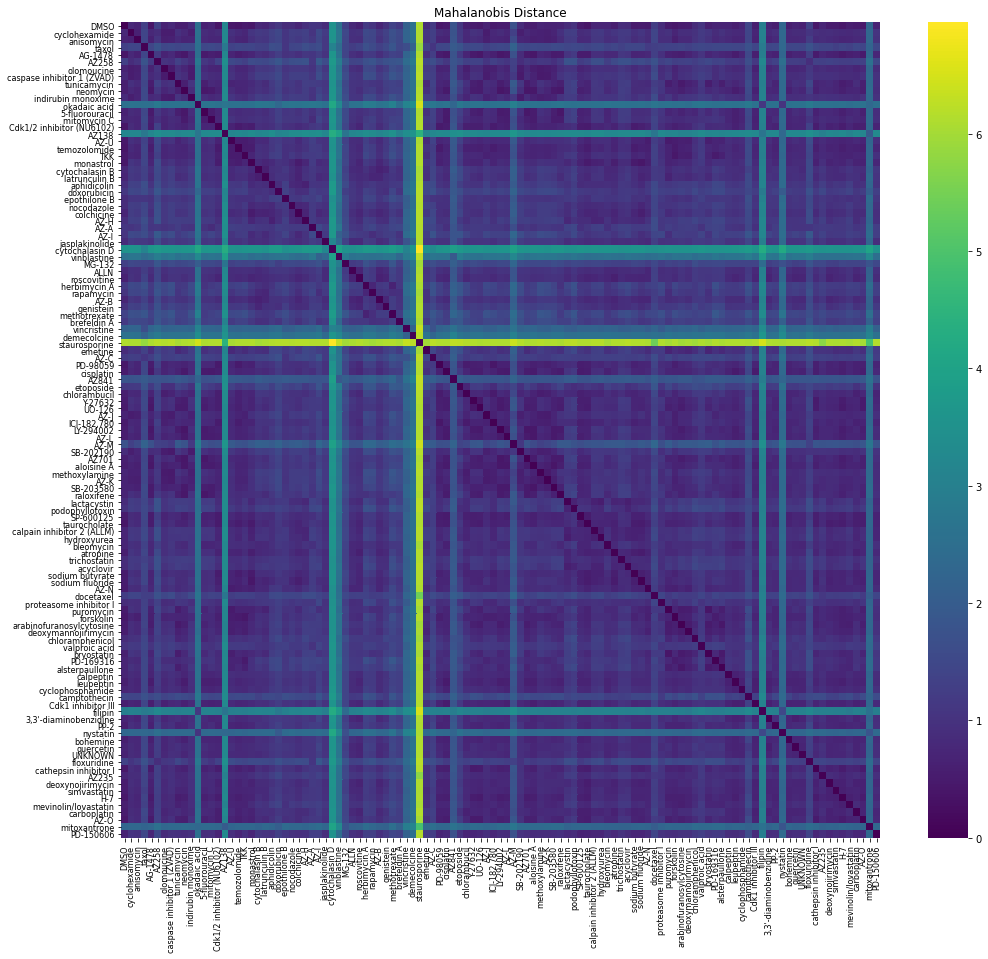

In [11]:
plt.figure(figsize=(17,15))
fig = sns.heatmap(mb_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=False)
plt.title('Mahalanobis Distance')
fig.set_xticklabels(comp_list, size=8)
fig.set_yticklabels(comp_list, size=8)
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


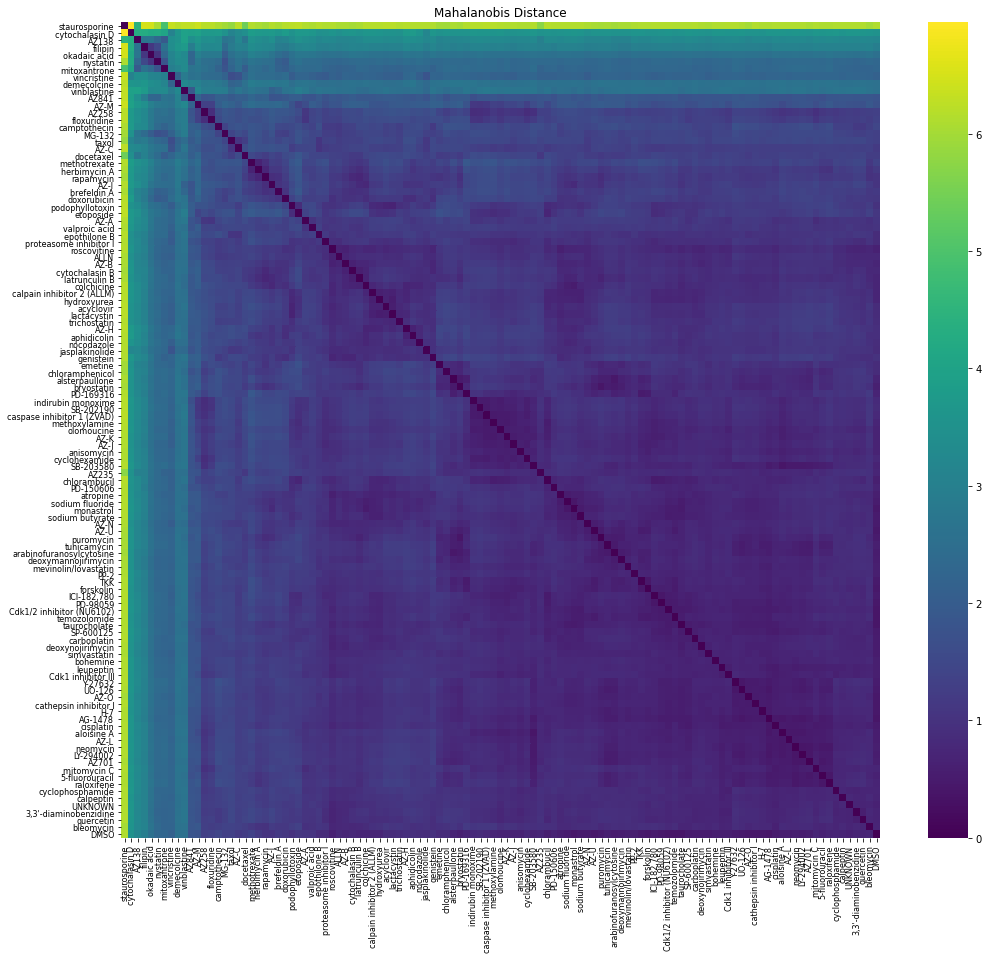

In [12]:
linkage = sch.linkage(mb_matrix, method='centroid', optimal_ordering=True)
dendro = sch.dendrogram(linkage, orientation='left', no_plot=True)

# Plot distance matrix.
labels = comp_list[dendro['leaves']]
omb = mb_matrix
index = dendro['leaves']
omb = omb[index,:]
omb = omb[:,index]
labels = comp_list[index]

plt.figure(figsize=(17,15))
fig = sns.heatmap(omb, xticklabels=labels, yticklabels=labels, cmap=plt.cm.viridis, annot=False)
plt.title('Mahalanobis Distance')
fig.set_xticklabels(labels, size=8)
fig.set_yticklabels(labels, size=8)
fig.figure.savefig(eval_dir + prefix + 'mahalanobis.png')
plt.show()

In [13]:
def std_matrix(x):
    sigma = np.eye(len(x[0]))
    std = np.std(x, axis=0)
    np.fill_diagonal(sigma, std)
    return sigma

def kl_distance(x, y):
    sigma_x = std_matrix(x)
    sigma_y = std_matrix(y)
    d = len(x[0])
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    
    kl = np.trace(np.linalg.inv(sigma_y) @ sigma_x)
    kl += ((mu_y - mu_x).T @ np.linalg.inv(sigma_y) @ (mu_y - mu_x)) - d
    kl += np.log(np.linalg.det(sigma_y) / np.linalg.det(sigma_x))
    return kl

def symmetric_kl(x, y):
    kl_xy = kl_distance(x, y)
    kl_yx = kl_distance(y, x)
    
    return 0.5 * (kl_xy + kl_yx)

In [14]:
kldist_matrix = np.empty(0)
i = 0
for x in comp_list:
    distances = []
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == x]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_x = test_z[is_compound].numpy()
    for y in comp_list:
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == y]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        comp_y = test_z[is_compound].numpy()
        distances.append(symmetric_kl(comp_x, comp_y))
        
    dist_array = np.array(distances)
    if kldist_matrix.any():
        kldist_matrix = np.vstack((kldist_matrix, dist_array))
    else:
        kldist_matrix = dist_array
kldist_matrix.shape

(113, 113)

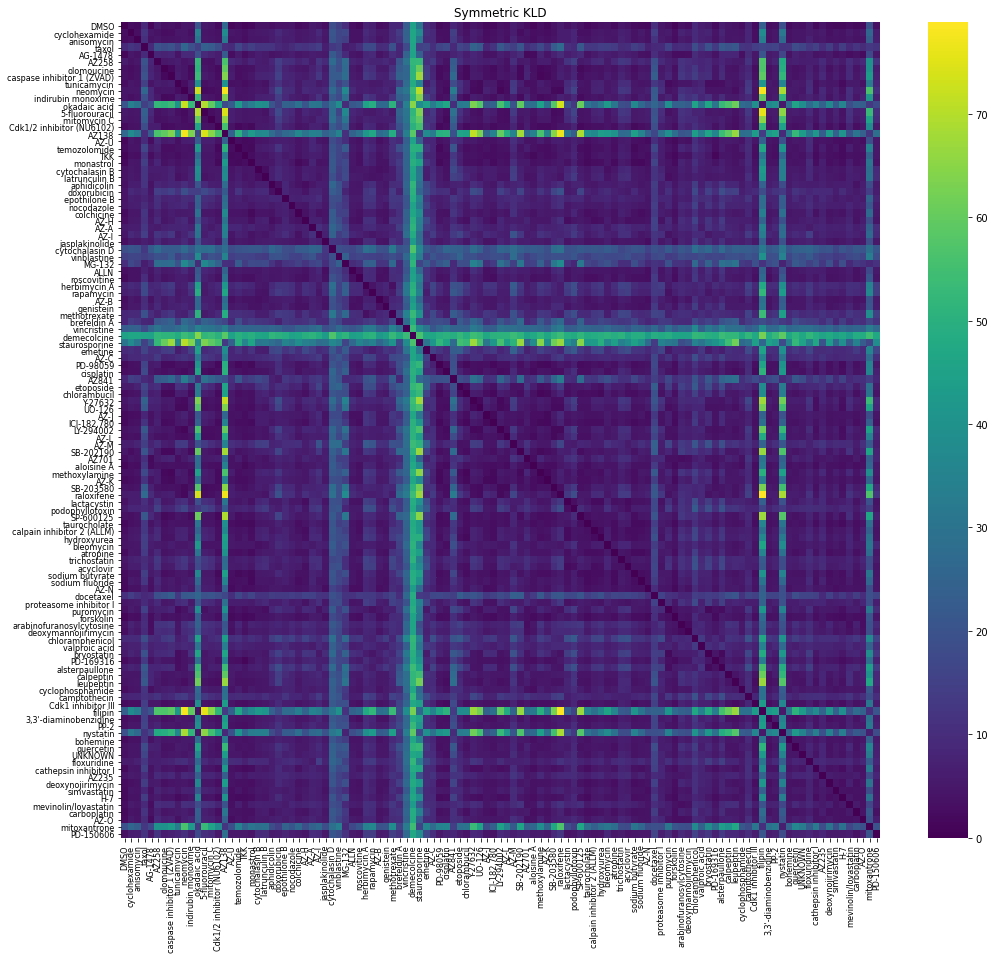

In [16]:
plt.figure(figsize=(17,15))
fig = sns.heatmap(kldist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=False)
fig.set_xticklabels(comp_list, size=8)
fig.set_yticklabels(comp_list, size=8)
plt.title('Symmetric KLD')
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


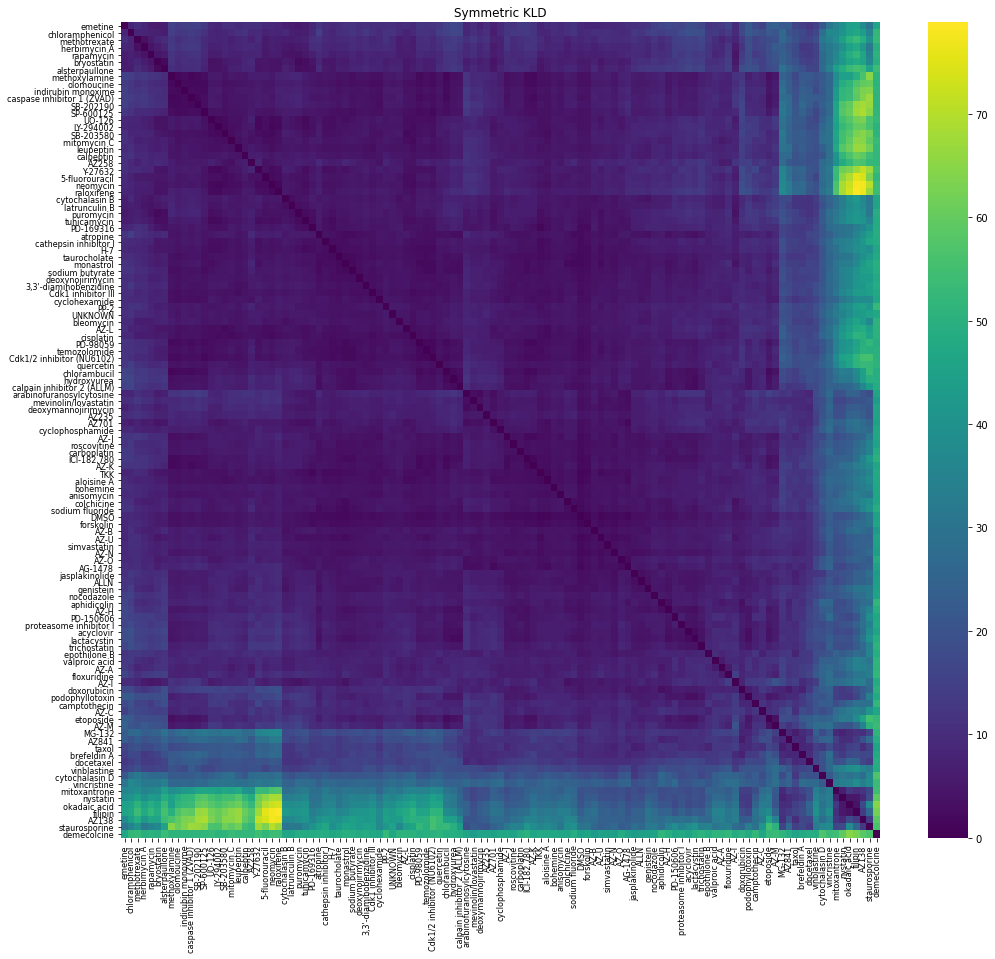

In [17]:
linkage = sch.linkage(kldist_matrix, method='centroid', optimal_ordering=True)
dendro = sch.dendrogram(linkage, orientation='left', no_plot=True)

# Plot distance matrix.
labels = comp_list[dendro['leaves']]
okl = kldist_matrix
index = dendro['leaves']
okl = okl[index,:]
okl = okl[:,index]
labels = comp_list[index]

plt.figure(figsize=(17,15))
fig = sns.heatmap(okl, xticklabels=labels, yticklabels=labels, cmap=plt.cm.viridis, annot=False)
fig.set_xticklabels(labels, size=8)
fig.set_yticklabels(labels, size=8)
fig.figure.savefig(eval_dir + prefix + 'sym_kld.png')
plt.title('Symmetric KLD')
plt.show()

## 2D Projection
Umap for scatter and density plots

In [21]:
leaves = dendro['leaves']
hc_comps = comp_list[leaves]
hue_df = pd.DataFrame(test_compounds, columns=['comp'])
hue_df['hue'] = -1
for idx, item in enumerate(hc_comps):
    hue_df.loc[hue_df.comp == item, 'hue'] = idx
hue_df

,comp,hue
0,methotrexate,2
1,ALLN,77
2,cyclohexamide,38
3,AZ-K,61
4,olomoucine,8
...,...,...
274729,SP-600125,12
274730,alsterpaullone,6
274731,nocodazole,79
274732,aphidicolin,80


In [22]:
reducer = umap.UMAP(random_state=22, verbose=True, low_memory=True)
z_2d = reducer.fit_transform(test_z)

UMAP(low_memory=True, random_state=22, verbose=True)
Construct fuzzy simplicial set
Tue Aug 25 14:52:21 2020 Finding Nearest Neighbors
Tue Aug 25 14:52:21 2020 Building RP forest with 31 trees
Tue Aug 25 14:53:50 2020 NN descent for 18 iterations
	 0  /  18
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	 8  /  18
	 9  /  18
	 10  /  18
	 11  /  18
Tue Aug 25 14:56:12 2020 Finished Nearest Neighbor Search
Tue Aug 25 14:56:27 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 25 15:01:30 2020 Finished embedding


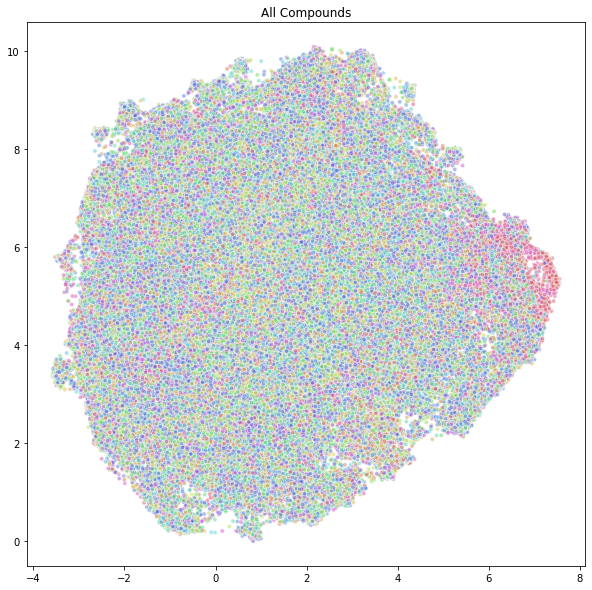

In [23]:
plt.figure(figsize=(10,10))
sns.scatterplot(z_2d[:,0], z_2d[:,1], alpha=0.5,size=1, hue=hue_df.hue, palette=sns.hls_palette(len(comp_list)),legend=False)
plt.title('All Compounds')
plt.show()

In [24]:
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds UMAP'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' UMAP'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.scatterplot(x, y, alpha=0.7, size=1, palette=sns.cubehelix_palette(1))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [25]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds Density Plot'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' Density Plot'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.kdeplot(x, y, legend=True, shade=True, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [11]:
def get_bokeh_image(z):
    x_hat = model.decode(z.to(device)).cpu().detach()[0]
    inp = x_hat.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    N = 96
    img = np.empty((N,N), dtype=np.uint32)
    view = img.view(dtype=np.uint8).reshape((N, N, 4))
    view[:,:,0] = inp[:,:,0] * 255 # copy red channel
    view[:,:,1] = inp[:,:,1] * 255 # copy blue channel
    view[:,:,2] = inp[:,:,2] * 255 # copy green channel
    view[:,:,3] = 255
    
    return [img]

output_notebook()

latent_cell = test_z[10]
y = latent_cell.numpy()
x = np.arange(z)
img = get_bokeh_image(latent_cell)

source = ColumnDataSource(data=dict(x=x, y=y))
img_source = ColumnDataSource(data=dict(img=img))

def modify_doc(doc):
    stem = figure(title="Stem plot", y_range=[-3, 3], x_range=[-1,z], tools='hover')
    stem.segment(x0='x', x1='x', y0=0, y1='y', source=source, color='green')
    stem.circle(x='x', y='y', source=source, size=5, color='orange')
    
    cell = figure(title='Image', height=96*4, width=96*4)
    cell.image_rgba(image='img', source=img_source,x=0,y=0, dw=96, dh=96)

    def update_value(attr, old, new):
        selected_z = z_slider.value
        value = val_slider.value
        y[selected_z] = value
        source.data = dict(x=x, y=y)
        recon = get_bokeh_image(torch.tensor(y))
        img_source.data = dict(img=recon)
        
    def update_dim(attr, old, new):
        selected_z = z_slider.value
        val_slider.value = y[selected_z]
        

    z_slider = Slider(start=0, end=255, value=0, step=1, title="Z selected")
    val_slider = Slider(start=-5, end=5, value=y[0], step=0.1, title='Dimension Value')
    z_slider.on_change('value', update_dim)
    val_slider.on_change('value', update_value)

    controls = column(z_slider, val_slider)
    layout = row(stem, cell)
    layout = column(controls, layout)
    #layout = column(controls, stem)
    doc.add_root(layout)
handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

Loading BokehJS ...

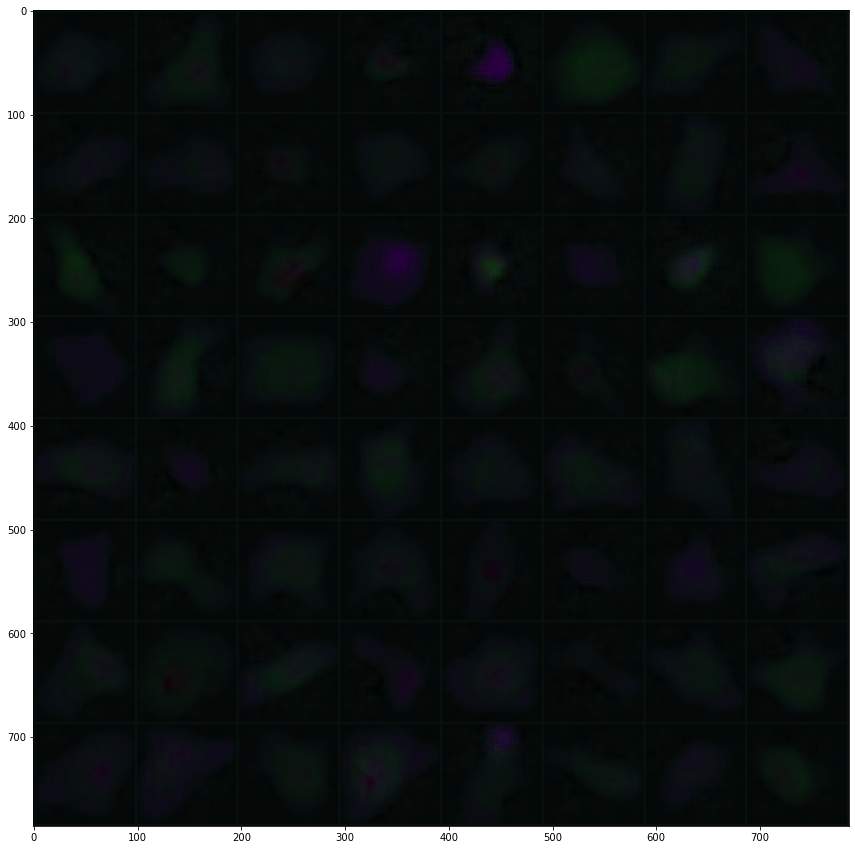

In [16]:
with torch.no_grad():
    imshow(torchvision.utils.make_grid(model.decode(test_z[64:64*2].to(device)).cpu()))

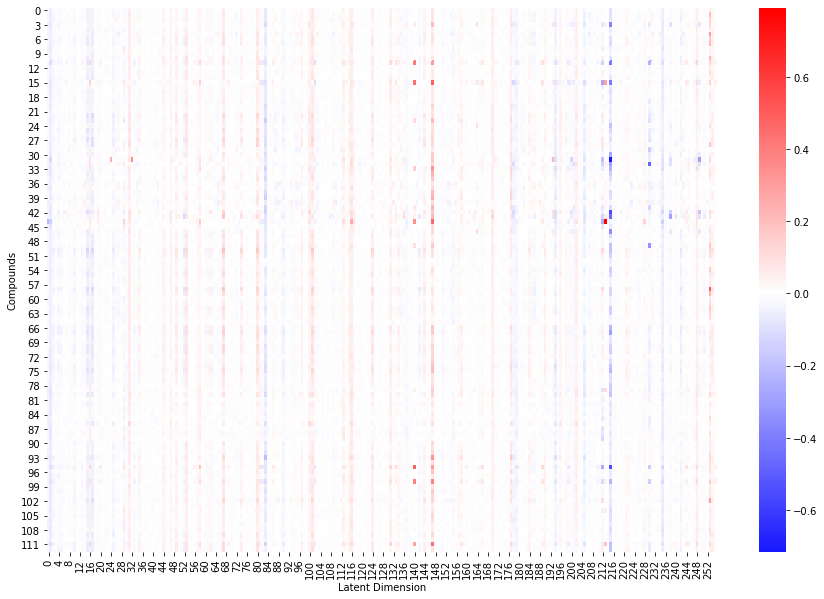

In [35]:
mean_vector = []
std_matrix = []
for compound in comp_list:
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    z_np = test_z[is_compound].numpy()
    mean = z_np.mean(axis=0)
    std = z_np.std(axis=0)
    mean_vector.append(mean)
    std_matrix.append(std)
mean_vector = np.asarray(mean_vector)
std_matrix = np.asarray(std_matrix)
plt.figure(figsize=(15,10))
sns.heatmap(mean_vector, cmap=plt.cm.bwr, center=0.0)
plt.xlabel('Latent Dimension')
plt.ylabel('Compounds')
plt.show()

In [41]:
usage = np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=0) / len(test_z)
mean_usage = np.mean(usage)
std_usage = np.std(usage)
print('Mean of Z features used: ', mean_usage)
print('STD of Z features used: ', std_usage)

Mean of Z features used:  0.39028828225665557
STD of Z features used:  0.008873957555637411


In [47]:
z_used = np.count_nonzero(test_z, axis=1)
mean_z_used = np.mean(z_used)
std_z_used = np.std(z_used)
print('Mean of Z features used: ', mean_z_used)
print('STD of Z features used: ', std_z_used)

Mean of Z features used:  255.9999890803468
STD of Z features used:  0.004266064081507905


In [48]:
z_used = np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=1)
mean_z_used = np.mean(z_used)
std_z_used = np.std(z_used)
print('Mean of Z features used: ', mean_z_used)
print('STD of Z features used: ', std_z_used)

Mean of Z features used:  99.91380025770381
STD of Z features used:  8.092045165820974


In [49]:
np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=1)

array([106, 100, 109, ..., 114, 118, 104])

In [5]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

label_mapping = image_dataset.class_to_idx

metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]
comp_list = compound_folder['Image_Metadata_Compound'].unique()
comp_count = {}
for comp_name in comp_list:
    comp_count[comp_name] = 0


loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=6,
    pin_memory=True,
    shuffle=False
)

mean = 0.
std = 0.
nb_samples = 0.
total_batches = len(loader)
for idx, (dat, labels) in enumerate(loader):
    if idx % (total_batches // 100) == 0:
        print("Batch ", idx, "/", total_batches)
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples
    
    for label in labels:
        compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
        comp_count[compound] = comp_count[compound] + 1

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)
comp_count

Batch  0 / 10732
Batch  107 / 10732
Batch  214 / 10732
Batch  321 / 10732
Batch  428 / 10732
Batch  535 / 10732
Batch  642 / 10732
Batch  749 / 10732
Batch  856 / 10732
Batch  963 / 10732
Batch  1070 / 10732
Batch  1177 / 10732
Batch  1284 / 10732
Batch  1391 / 10732
Batch  1498 / 10732
Batch  1605 / 10732
Batch  1712 / 10732
Batch  1819 / 10732
Batch  1926 / 10732
Batch  2033 / 10732
Batch  2140 / 10732
Batch  2247 / 10732
Batch  2354 / 10732
Batch  2461 / 10732
Batch  2568 / 10732
Batch  2675 / 10732
Batch  2782 / 10732
Batch  2889 / 10732
Batch  2996 / 10732
Batch  3103 / 10732
Batch  3210 / 10732
Batch  3317 / 10732
Batch  3424 / 10732
Batch  3531 / 10732
Batch  3638 / 10732
Batch  3745 / 10732
Batch  3852 / 10732
Batch  3959 / 10732
Batch  4066 / 10732
Batch  4173 / 10732
Batch  4280 / 10732
Batch  4387 / 10732
Batch  4494 / 10732
Batch  4601 / 10732
Batch  4708 / 10732
Batch  4815 / 10732
Batch  4922 / 10732
Batch  5029 / 10732
Batch  5136 / 10732
Batch  5243 / 10732
Batch  5350 

{'DMSO': 210508,
 'cyclohexamide': 11143,
 'anisomycin': 7231,
 'taxol': 29787,
 'AG-1478': 23830,
 'AZ258': 8212,
 'olomoucine': 14407,
 'caspase inhibitor 1 (ZVAD)': 17927,
 'tunicamycin': 11943,
 'neomycin': 18408,
 'indirubin monoxime': 12937,
 'okadaic acid': 13751,
 '5-fluorouracil': 15435,
 'mitomycin C': 12574,
 'Cdk1/2 inhibitor (NU6102)': 15324,
 'AZ138': 2899,
 'AZ-U': 17053,
 'temozolomide': 17944,
 'TKK': 20075,
 'monastrol': 32543,
 'cytochalasin B': 8705,
 'latrunculin B': 10176,
 'aphidicolin': 10631,
 'doxorubicin': 11154,
 'epothilone B': 5224,
 'nocodazole': 4602,
 'colchicine': 9490,
 'AZ-H': 11160,
 'AZ-A': 5086,
 'AZ-I': 13255,
 'jasplakinolide': 7530,
 'cytochalasin D': 6640,
 'vinblastine': 1844,
 'MG-132': 4428,
 'ALLN': 6672,
 'roscovitine': 9278,
 'herbimycin A': 8806,
 'rapamycin': 8918,
 'AZ-B': 8873,
 'genistein': 7555,
 'methotrexate': 8205,
 'brefeldin A': 5391,
 'vincristine': 1060,
 'demecolcine': 524,
 'staurosporine': 4692,
 'emetine': 4977,
 'AZ-C':

In [19]:
compound_count = pd.DataFrame.from_dict(comp_count, orient='index', columns=['count']).sort_values(by='count', ascending=False)
print(compound_count.to_string())

                             count
DMSO                        210508
monastrol                    32543
taxol                        29787
AG-1478                      23830
TKK                          20075
alsterpaullone               19815
Y-27632                      19704
neomycin                     18408
temozolomide                 17944
caspase inhibitor 1 (ZVAD)   17927
SB-203580                    17184
AZ-U                         17053
arabinofuranosylcytosine     17003
ICI-182,780                  16690
UO-126                       16279
LY-294002                    16129
methoxylamine                16016
puromycin                    15634
5-fluorouracil               15435
Cdk1/2 inhibitor (NU6102)    15324
forskolin                    15271
PD-169316                    15248
AZ-K                         15217
cisplatin                    15154
chlorambucil                 15125
PD-98059                     14669
olomoucine                   14407
bryostatin          

In [27]:
compound_count['count'].count()

113

In [24]:
compound_count['proportion'] = compound_count['count'] / compound_count['count'].sum()

In [25]:
print(compound_count.to_string())

                             count  proportion
DMSO                        210508    0.153245
monastrol                    32543    0.023691
taxol                        29787    0.021684
AG-1478                      23830    0.017348
TKK                          20075    0.014614
alsterpaullone               19815    0.014425
Y-27632                      19704    0.014344
neomycin                     18408    0.013401
temozolomide                 17944    0.013063
caspase inhibitor 1 (ZVAD)   17927    0.013050
SB-203580                    17184    0.012510
AZ-U                         17053    0.012414
arabinofuranosylcytosine     17003    0.012378
ICI-182,780                  16690    0.012150
UO-126                       16279    0.011851
LY-294002                    16129    0.011742
methoxylamine                16016    0.011659
puromycin                    15634    0.011381
5-fluorouracil               15435    0.011236
Cdk1/2 inhibitor (NU6102)    15324    0.011156
forskolin    

In [15]:
mean

tensor([0.0335, 0.0568, 0.0550])

In [16]:
std

tensor([0.0669, 0.0882, 0.0839])

In [22]:
test_labels

,Image_FileName_DAPI,Image_Metadata_Compound,Image_Metadata_Plate_DAPI
id,,,
